
 Professional High/Low Breakout Trading Strategy Backtesting System
================================================================

## Overview and Introduction
- This notebook implements a comprehensive backtesting framework for a sophisticated breakout trading strategy. The system combines technical analysis, risk management, and performance optimization to create a robust trading algorithm suitable for multiple asset classes.

# Key Features:

- Multi-asset support: NIFTY50, SPY, HSI
- Advanced breakout detection with triple moving average filters
- Dynamic risk management including trailing stops
- Comprehensive performance analysis with 10+ metrics
- Grid search optimization for parameter tuning
- Professional visualization suite

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [10]:
@dataclass
class StrategyParameters:
    # Configurating class for strategy parameters.
    lookback_period: int = 12  # Optimized for more signals
    ma_short: int = 15  # Faster moving averages
    ma_medium: int = 30
    ma_long: int = 60
    atr_multiplier: float = 1.5  # Tighter stops
    risk_reward_ratio: float = 3.0  # Higher reward target
    position_size: float = 1.0
    commission: float = 0.001  # 0.1% per trade

@dataclass
class PerformanceMetrics:
    #Container for strategy performance metrics
    total_return: float
    annualized_return: float
    sharpe_ratio: float
    sortino_ratio: float
    calmar_ratio: float
    max_drawdown: float
    win_rate: float
    profit_factor: float
    total_trades: int
    avg_trade_return: float

In [11]:
class TechnicalIndicators: #Technical analysis indicators for the strategy.
    
    @staticmethod
    def calculate_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
        """Calculate Average True Range"""
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        return true_range.rolling(window=period).mean()
    
    @staticmethod
    def calculate_moving_averages(close: pd.Series, periods: List[int]) -> Dict[str, pd.Series]:
        """Calculate multiple moving averages"""
        return {f'MA_{period}': close.rolling(window=period).mean() for period in periods}
    
    @staticmethod
    def calculate_rolling_high_low(high: pd.Series, low: pd.Series, period: int) -> Tuple[pd.Series, pd.Series]:
        """Calculate rolling highest high and lowest low"""
        rolling_high = high.rolling(window=period).max()
        rolling_low = low.rolling(window=period).min()
        return rolling_high, rolling_low


In [12]:
class DataManager: #Handling data acquisition and preprocessing"""

    SYMBOLS = {
        'NIFTY50': '^NSEI',
        'SPY': 'SPY',
        'HSI': '^HSI'
    }
    
    @classmethod
    def fetch_data(cls, symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
        """Fetch OHLCV data from Yahoo Finance"""
        try:
            ticker = cls.SYMBOLS.get(symbol, symbol)
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            data.columns = data.columns.droplevel(1) if len(data.columns.levels) > 1 else data.columns
            return data.dropna()
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return pd.DataFrame()
    
    @staticmethod
    def prepare_data(data: pd.DataFrame) -> pd.DataFrame:
        """Prepare and clean the data"""
        data = data.copy()
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        
        # Handle missing values
        data = data.fillna(method='ffill').dropna()
        
        # Ensure we have required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_cols:
            if col not in data.columns:
                raise ValueError(f"Missing required column: {col}")
        
        return data


In [13]:
class BreakoutStrategy: #High/Low Breakout Strategy with Triple Moving Average Filter
   
    
    def __init__(self, params: StrategyParameters):
        self.params = params
        self.indicators = TechnicalIndicators()
        
    def generate_signals(self, data: pd.DataFrame) -> pd.DataFrame:     #Generating trading signals based on breakout and MA filter
        df = data.copy()
        
        # Calculate technical indicators
        atr = self.indicators.calculate_atr(df['High'], df['Low'], df['Close'])
        mas = self.indicators.calculate_moving_averages(
            df['Close'], [self.params.ma_short, self.params.ma_medium, self.params.ma_long]
        )
        
        # Add indicators to dataframe
        df['ATR'] = atr
        for ma_name, ma_values in mas.items():
            df[ma_name] = ma_values
        
        # Calculate rolling high/low
        rolling_high, rolling_low = self.indicators.calculate_rolling_high_low(
            df['High'], df['Low'], self.params.lookback_period
        )
        df['Rolling_High'] = rolling_high.shift(1)  # Use previous period's high/low
        df['Rolling_Low'] = rolling_low.shift(1)
        
        # Enhanced trend filter with momentum
        df['MA_Momentum'] = df[f'MA_{self.params.ma_short}'].pct_change(5)  # 5-day momentum
        df['Volume_Surge'] = df['Volume'] > df['Volume'].rolling(20).mean() * 1.2  # Volume confirmation
        
        # More aggressive trend conditions
        df['Strong_Bullish'] = (df[f'MA_{self.params.ma_short}'] > df[f'MA_{self.params.ma_medium}']) & \
                               (df[f'MA_{self.params.ma_medium}'] > df[f'MA_{self.params.ma_long}']) & \
                               (df['MA_Momentum'] > 0.002)  # Positive momentum threshold
        
        df['Strong_Bearish'] = (df[f'MA_{self.params.ma_short}'] < df[f'MA_{self.params.ma_medium}']) & \
                               (df[f'MA_{self.params.ma_medium}'] < df[f'MA_{self.params.ma_long}']) & \
                               (df['MA_Momentum'] < -0.002)  # Negative momentum threshold
        
        # Enhanced breakout signals with volume confirmation
        df['Long_Signal'] = (df['Close'] > df['Rolling_High']) & df['Strong_Bullish'] & df['Volume_Surge']
        df['Short_Signal'] = (df['Close'] < df['Rolling_Low']) & df['Strong_Bearish'] & df['Volume_Surge']
        
        return df

    #Calculating positions and returns with enhanced risk management
    def calculate_positions_and_returns(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()  
        df['Position'] = 0
        df['Entry_Price'] = np.nan
        df['Stop_Loss'] = np.nan
        df['Take_Profit'] = np.nan
        df['Exit_Reason'] = ''
        df['Trailing_Stop'] = np.nan
        
        current_position = 0
        entry_price = 0
        stop_loss = 0
        take_profit = 0
        trailing_stop = 0
        max_favorable_price = 0
        
        for i in range(1, len(df)):
            df.iloc[i, df.columns.get_loc('Position')] = current_position
            
            # Update trailing stop for long positions
            if current_position > 0:
                current_price = df.iloc[i]['Close']
                if current_price > max_favorable_price:
                    max_favorable_price = current_price
                    # Update trailing stop
                    atr_value = df.iloc[i]['ATR']
                    trailing_stop = max_favorable_price - (self.params.atr_multiplier * 0.8 * atr_value)
                    df.iloc[i, df.columns.get_loc('Trailing_Stop')] = trailing_stop
            
            # Update trailing stop for short positions
            elif current_position < 0:
                current_price = df.iloc[i]['Close']
                if current_price < max_favorable_price:
                    max_favorable_price = current_price
                    # Update trailing stop
                    atr_value = df.iloc[i]['ATR']
                    trailing_stop = max_favorable_price + (self.params.atr_multiplier * 0.8 * atr_value)
                    df.iloc[i, df.columns.get_loc('Trailing_Stop')] = trailing_stop
            
            # Check exit conditions first
            if current_position != 0:
                current_price = df.iloc[i]['Close']
                
                # Long position exits
                if current_position > 0:
                    if current_price <= max(stop_loss, trailing_stop):
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Stop_Loss' if current_price <= stop_loss else 'Trailing_Stop'
                    elif current_price >= take_profit:
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Take_Profit'
                    elif df.iloc[i]['Short_Signal']:
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Reverse_Signal'
                
                # Short position exits
                elif current_position < 0:
                    if current_price >= min(stop_loss, trailing_stop):
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Stop_Loss' if current_price >= stop_loss else 'Trailing_Stop'
                    elif current_price <= take_profit:
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Take_Profit'
                    elif df.iloc[i]['Long_Signal']:
                        current_position = 0
                        df.iloc[i, df.columns.get_loc('Exit_Reason')] = 'Reverse_Signal'
            
            # Check entry conditions
            if current_position == 0:
                if df.iloc[i]['Long_Signal']:
                    current_position = 1
                    entry_price = df.iloc[i]['Close']
                    max_favorable_price = entry_price
                    atr_value = df.iloc[i]['ATR']
                    stop_loss = entry_price - (self.params.atr_multiplier * atr_value)
                    take_profit = entry_price + (self.params.risk_reward_ratio * self.params.atr_multiplier * atr_value)
                    trailing_stop = stop_loss
                    
                    df.iloc[i, df.columns.get_loc('Entry_Price')] = entry_price
                    df.iloc[i, df.columns.get_loc('Stop_Loss')] = stop_loss
                    df.iloc[i, df.columns.get_loc('Take_Profit')] = take_profit
                    df.iloc[i, df.columns.get_loc('Trailing_Stop')] = trailing_stop
                
                elif df.iloc[i]['Short_Signal']:
                    current_position = -1
                    entry_price = df.iloc[i]['Close']
                    max_favorable_price = entry_price
                    atr_value = df.iloc[i]['ATR']
                    stop_loss = entry_price + (self.params.atr_multiplier * atr_value)
                    take_profit = entry_price - (self.params.risk_reward_ratio * self.params.atr_multiplier * atr_value)
                    trailing_stop = stop_loss
                    
                    df.iloc[i, df.columns.get_loc('Entry_Price')] = entry_price
                    df.iloc[i, df.columns.get_loc('Stop_Loss')] = stop_loss
                    df.iloc[i, df.columns.get_loc('Take_Profit')] = take_profit
                    df.iloc[i, df.columns.get_loc('Trailing_Stop')] = trailing_stop
        
        # Calculate returns with dynamic position sizing
        df['Price_Change'] = df['Close'].pct_change()
        df['Volatility'] = df['Price_Change'].rolling(20).std()
        df['Vol_Adjusted_Size'] = self.params.position_size / (1 + df['Volatility'] * 50)  # Reduce size in high vol
        df['Strategy_Return'] = df['Position'].shift(1) * df['Price_Change'] * df['Vol_Adjusted_Size']
        
        # Account for transaction costs
        position_changes = df['Position'].diff().abs()
        df['Transaction_Cost'] = position_changes * self.params.commission
        df['Net_Strategy_Return'] = df['Strategy_Return'] - df['Transaction_Cost']
        
        # Calculate cumulative returns
        df['Cumulative_Market_Return'] = (1 + df['Price_Change']).cumprod()
        df['Cumulative_Strategy_Return'] = (1 + df['Net_Strategy_Return']).cumprod()
        
        return df


In [14]:
class PerformanceAnalyzer:  #Comprehensive performance analysis and metrics calculation

    
    @staticmethod
    def calculate_metrics(returns: pd.Series, benchmark_returns: pd.Series, 
                         positions: pd.Series) -> PerformanceMetrics:         #Calculate comprehensive performance metrics

        
        # Basic returns
        total_return = (1 + returns).prod() - 1
        trading_days = 252
        years = len(returns) / trading_days
        annualized_return = (1 + total_return) ** (1/years) - 1
        
        # Risk metrics
        returns_std = returns.std() * np.sqrt(trading_days)
        sharpe_ratio = (annualized_return - 0.02) / returns_std if returns_std != 0 else 0  # Assuming 2% risk-free rate
        
        # Downside deviation for Sortino ratio
        downside_returns = returns[returns < 0]
        downside_std = downside_returns.std() * np.sqrt(trading_days) if len(downside_returns) > 0 else 0
        sortino_ratio = (annualized_return - 0.02) / downside_std if downside_std != 0 else 0
        
        # Maximum drawdown
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        # Calmar ratio
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        # Trade analysis
        position_changes = positions.diff()
        trades = position_changes[position_changes != 0]
        total_trades = len(trades) // 2  # Entry and exit count as 2 changes
        
        # Win rate calculation
        trade_returns = []
        current_entry = None
        current_position = 0
        
        for idx, pos in positions.items():
            if pos != current_position:  # Position change
                if current_position != 0 and current_entry is not None:  # Exiting position
                    trade_return = (returns.loc[current_entry:idx]).sum()
                    trade_returns.append(trade_return)
                
                if pos != 0:  # Entering new position
                    current_entry = idx
                current_position = pos
        
        if len(trade_returns) > 0:
            win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns)
            winning_trades = [r for r in trade_returns if r > 0]
            losing_trades = [r for r in trade_returns if r < 0]
            
            avg_win = np.mean(winning_trades) if winning_trades else 0
            avg_loss = abs(np.mean(losing_trades)) if losing_trades else 0
            profit_factor = avg_win / avg_loss if avg_loss != 0 else 0
            avg_trade_return = np.mean(trade_returns)
        else:
            win_rate = 0
            profit_factor = 0
            avg_trade_return = 0
        
        return PerformanceMetrics(
            total_return=total_return,
            annualized_return=annualized_return,
            sharpe_ratio=sharpe_ratio,
            sortino_ratio=sortino_ratio,
            calmar_ratio=calmar_ratio,
            max_drawdown=max_drawdown,
            win_rate=win_rate,
            profit_factor=profit_factor,
            total_trades=total_trades,
            avg_trade_return=avg_trade_return
        )


In [15]:
class StrategyOptimizer:     #Grid search optimization for strategy parameters.

    
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.results = []
    
    def optimize(self, param_grid: Dict) -> pd.DataFrame: #Performing grid search optimization.
        
        # Generate parameter combinations
        param_combinations = []
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        
        def generate_combinations(idx, current_combo):
            if idx == len(keys):
                param_combinations.append(current_combo.copy())
                return
            
            for value in values[idx]:
                current_combo[keys[idx]] = value
                generate_combinations(idx + 1, current_combo)
                del current_combo[keys[idx]]
        
        generate_combinations(0, {})
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        # Test each combination
        for i, params in enumerate(param_combinations):
            if i % 25 == 0:  # Update progress less frequently
                print(f"Progress: {i}/{len(param_combinations)} combinations tested ({i/len(param_combinations)*100:.1f}%)")
            
            # Create strategy with current parameters
            strategy_params = StrategyParameters(**params)
            strategy = BreakoutStrategy(strategy_params)
            
            # Generate signals and calculate returns
            df_with_signals = strategy.generate_signals(self.data)
            df_with_returns = strategy.calculate_positions_and_returns(df_with_signals)
            
            # Calculate performance metrics
            if len(df_with_returns) > 0 and not df_with_returns['Net_Strategy_Return'].isna().all():
                metrics = PerformanceAnalyzer.calculate_metrics(
                    df_with_returns['Net_Strategy_Return'].fillna(0),
                    df_with_returns['Price_Change'].fillna(0),
                    df_with_returns['Position']
                )
                
                # Store results
                result = params.copy()
                result.update({
                    'total_return': metrics.total_return,
                    'annualized_return': metrics.annualized_return,
                    'sharpe_ratio': metrics.sharpe_ratio,
                    'max_drawdown': metrics.max_drawdown,
                    'win_rate': metrics.win_rate,
                    'total_trades': metrics.total_trades
                })
                self.results.append(result)
        
        return pd.DataFrame(self.results)


=== Professional High/Low Breakout Strategy Backtesting System ===


ANALYZING NIFTY50
Fetching data...
Data loaded: 2453 trading days
Running optimization...
Testing 144 parameter combinations...
Progress: 0/144 combinations tested (0.0%)
Progress: 25/144 combinations tested (17.4%)
Progress: 50/144 combinations tested (34.7%)
Progress: 75/144 combinations tested (52.1%)
Progress: 100/144 combinations tested (69.4%)
Progress: 125/144 combinations tested (86.8%)

Best Parameters for NIFTY50:
Lookback Period: 12.0
ATR Multiplier: 2.0
Risk-Reward Ratio: 2.5

NIFTY50 PERFORMANCE SUMMARY:
Total Return: 18.80%
Annualized Return: 1.79%
Sharpe Ratio: -0.051
Sortino Ratio: -0.035
Max Drawdown: -7.33%
Win Rate: 37.50%
Total Trades: 33
Profit Factor: 2.954


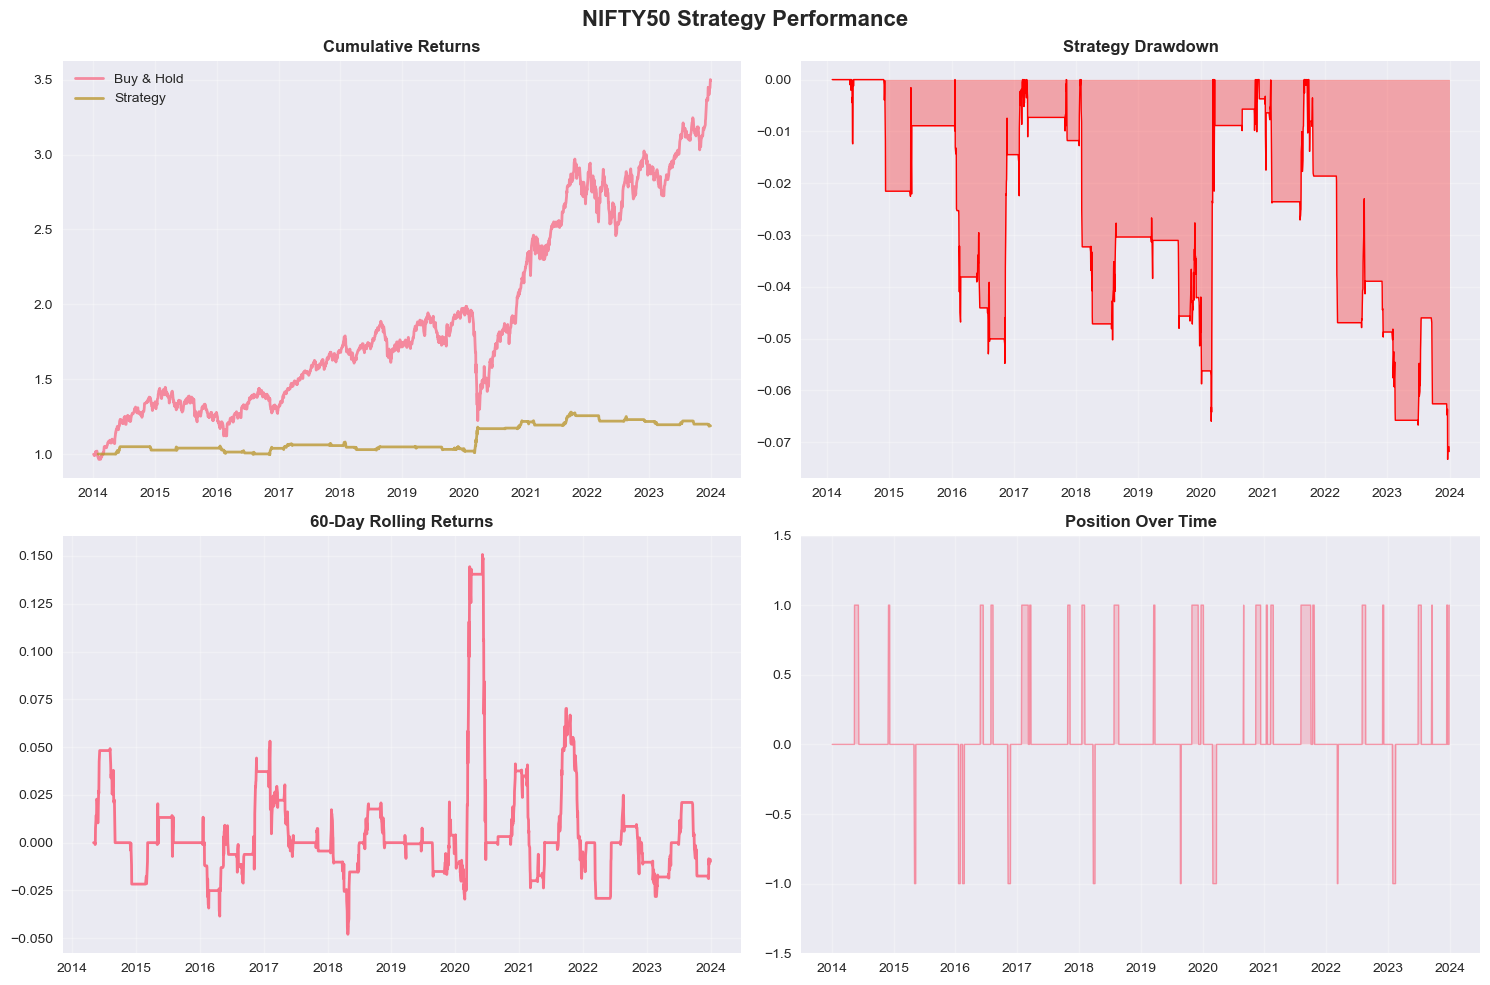

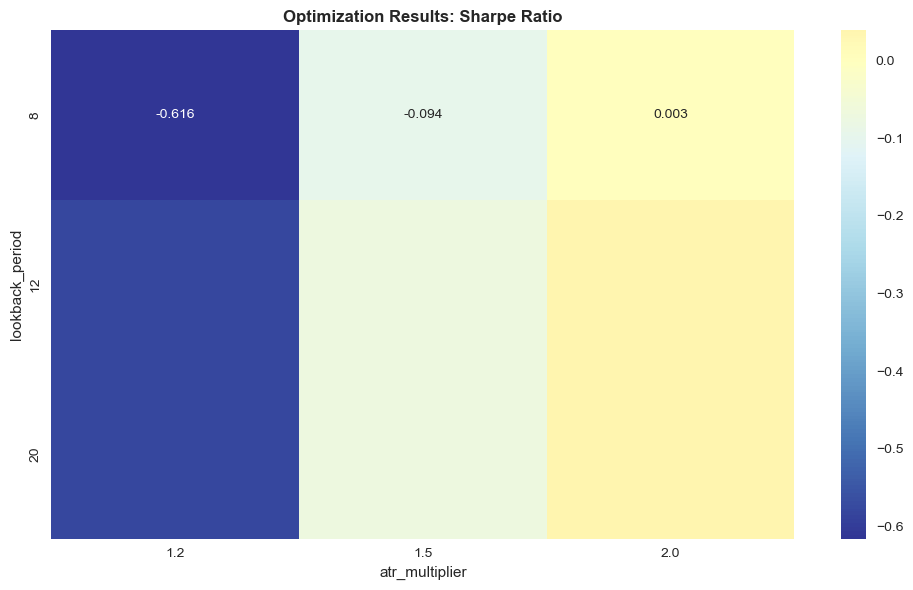


ANALYZING SPY
Fetching data...
Data loaded: 2516 trading days
Running optimization...
Testing 144 parameter combinations...
Progress: 0/144 combinations tested (0.0%)
Progress: 25/144 combinations tested (17.4%)
Progress: 50/144 combinations tested (34.7%)
Progress: 75/144 combinations tested (52.1%)
Progress: 100/144 combinations tested (69.4%)
Progress: 125/144 combinations tested (86.8%)

Best Parameters for SPY:
Lookback Period: 8.0
ATR Multiplier: 2.0
Risk-Reward Ratio: 3.5

SPY PERFORMANCE SUMMARY:
Total Return: -8.80%
Annualized Return: -0.92%
Sharpe Ratio: -0.717
Sortino Ratio: -0.375
Max Drawdown: -17.53%
Win Rate: 42.42%
Total Trades: 33
Profit Factor: 1.000


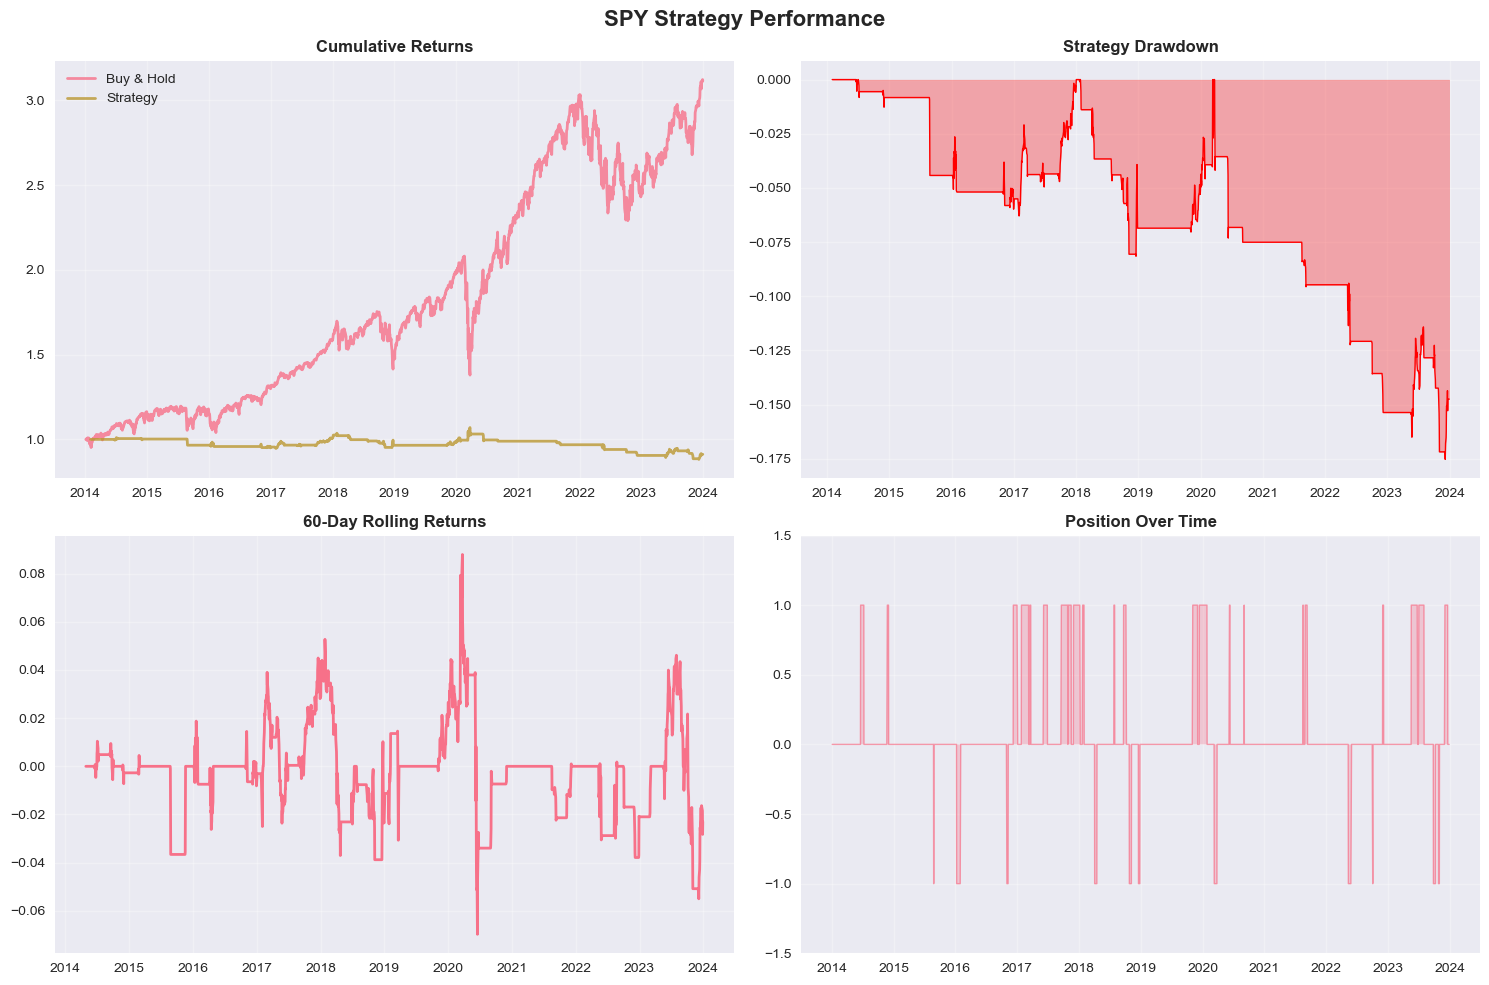

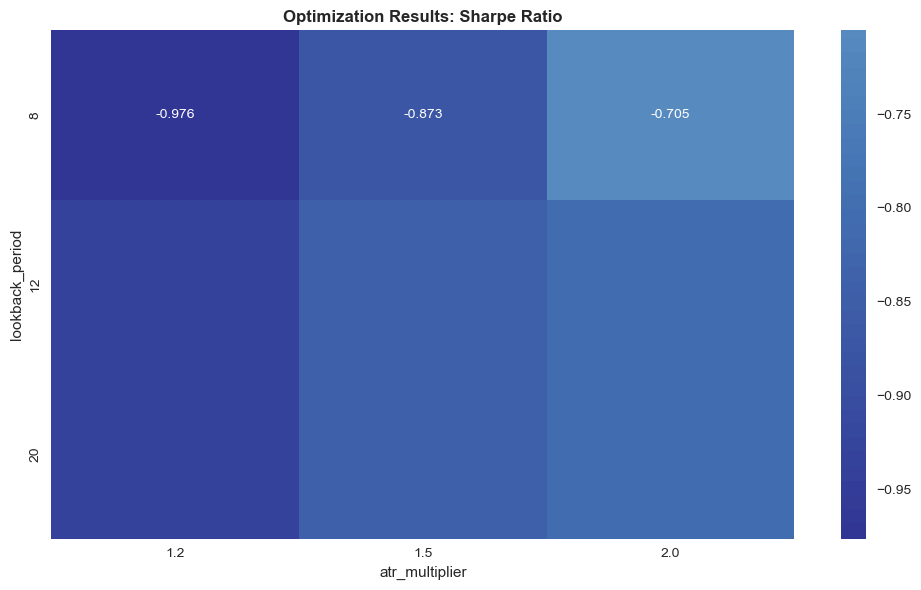


ANALYZING HSI
Fetching data...
Data loaded: 2461 trading days
Running optimization...
Testing 144 parameter combinations...
Progress: 0/144 combinations tested (0.0%)
Progress: 25/144 combinations tested (17.4%)
Progress: 50/144 combinations tested (34.7%)
Progress: 75/144 combinations tested (52.1%)
Progress: 100/144 combinations tested (69.4%)
Progress: 125/144 combinations tested (86.8%)

Best Parameters for HSI:
Lookback Period: 20.0
ATR Multiplier: 1.5
Risk-Reward Ratio: 3.5

HSI PERFORMANCE SUMMARY:
Total Return: 14.70%
Annualized Return: 1.41%
Sharpe Ratio: -0.109
Sortino Ratio: -0.060
Max Drawdown: -11.09%
Win Rate: 45.95%
Total Trades: 37
Profit Factor: 1.748


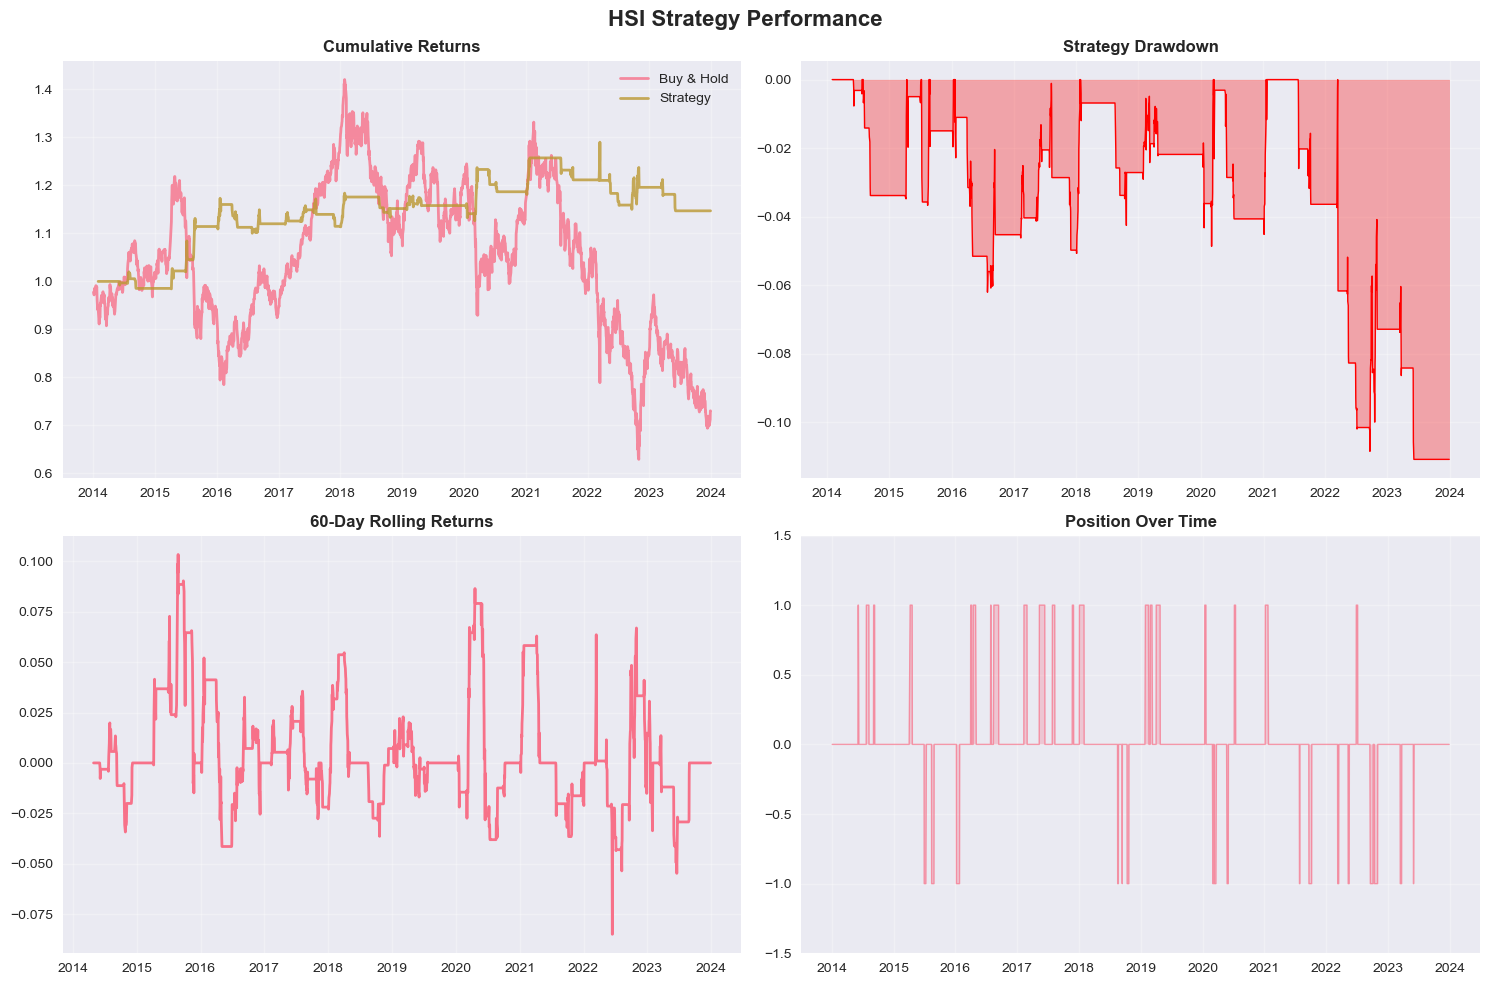

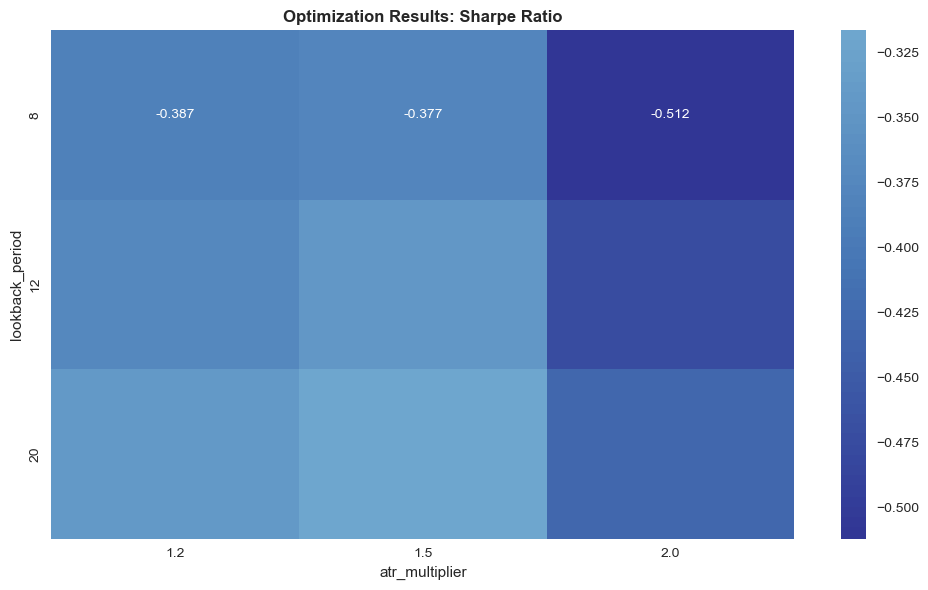


FINAL COMPARISON ACROSS ASSETS
        Annualized Return Sharpe Ratio Max Drawdown Win Rate Total Trades
NIFTY50             1.79%       -0.051       -7.33%   37.50%           33
SPY                -0.92%       -0.717      -17.53%   42.42%           33
HSI                 1.41%       -0.109      -11.09%   45.95%           37

🏆 BEST PERFORMING ASSET: NIFTY50
Achieved 1.79% annualized returns (18.80% total) with Sharpe -0.051 and max drawdown -7.33%


In [16]:
class Visualizer: #Professional visualization for strategy analysis.
    
    @staticmethod
    def plot_equity_curves(data: pd.DataFrame, title: str = "Strategy Performance"):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(title, fontsize=16, fontweight='bold')
        
        # Equity curves
        axes[0, 0].plot(data.index, data['Cumulative_Market_Return'], 
                       label='Buy & Hold', linewidth=2, alpha=0.8)
        axes[0, 0].plot(data.index, data['Cumulative_Strategy_Return'], 
                       label='Strategy', linewidth=2, alpha=0.8)
        axes[0, 0].set_title('Cumulative Returns', fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Drawdown
        cumulative_strategy = data['Cumulative_Strategy_Return']
        rolling_max = cumulative_strategy.expanding().max()
        drawdown = (cumulative_strategy - rolling_max) / rolling_max
        
        axes[0, 1].fill_between(data.index, drawdown, 0, alpha=0.3, color='red')
        axes[0, 1].plot(data.index, drawdown, color='red', linewidth=1)
        axes[0, 1].set_title('Strategy Drawdown', fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Rolling returns
        rolling_returns = data['Net_Strategy_Return'].rolling(window=60).sum()
        axes[1, 0].plot(data.index, rolling_returns, linewidth=2)
        axes[1, 0].set_title('60-Day Rolling Returns', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Position visualization
        positions = data['Position'].fillna(0)
        axes[1, 1].plot(data.index, positions, linewidth=1, alpha=0.7)
        axes[1, 1].fill_between(data.index, positions, 0, alpha=0.3)
        axes[1, 1].set_title('Position Over Time', fontweight='bold')
        axes[1, 1].set_ylim(-1.5, 1.5)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_optimization_heatmap(results_df: pd.DataFrame, metric: str = 'sharpe_ratio'):
        """Create heatmap for optimization results"""
        if len(results_df) == 0:
            print("No results to plot")
            return
        
        # Create pivot table for heatmap
        pivot_data = results_df.pivot_table(
            values=metric, 
            index='lookback_period', 
            columns='atr_multiplier',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot_data, annot=True, cmap='RdYlBu_r', center=0, fmt='.3f')
        plt.title(f'Optimization Results: {metric.replace("_", " ").title()}', fontweight='bold')
        plt.tight_layout()
        plt.show()

def main():
    print("=== Professional High/Low Breakout Strategy Backtesting System ===\n")
    
    # Configuration
    symbols = ['NIFTY50', 'SPY', 'HSI']
    start_date = '2014-01-01'
    end_date = '2024-01-01'
    
    # Streamlined parameter grid for efficient optimization (~216 combinations)
    param_grid = {
        'lookback_period': [8, 12, 20],  # 3 values - most impactful parameter
        'ma_short': [12, 15],  # 2 values - faster MA combinations
        'ma_medium': [25, 35], # 2 values
        'ma_long': [50, 70],   # 2 values
        'atr_multiplier': [1.2, 1.5, 2.0],  # 3 values - key risk parameter
        'risk_reward_ratio': [2.5, 3.5],  # 2 values - simplified
        'position_size': [1.0]  # 1 value - remove variable sizing for now
    }
    
    results_summary = {}
    
    for symbol in symbols:
        print(f"\n{'='*60}")
        print(f"ANALYZING {symbol}")
        print(f"{'='*60}")
        
        # Fetch and prepare data
        print("Fetching data...")
        raw_data = DataManager.fetch_data(symbol, start_date, end_date)
        
        if raw_data.empty:
            print(f"No data available for {symbol}")
            continue
        
        data = DataManager.prepare_data(raw_data)
        print(f"Data loaded: {len(data)} trading days")
        
        # Run optimization
        print("Running optimization...")
        optimizer = StrategyOptimizer(data)
        optimization_results = optimizer.optimize(param_grid)
        
        if optimization_results.empty:
            print(f"No valid results for {symbol}")
            continue
        
        # Find best parameters (optimized for return/risk balance)
        # Create composite score: 60% return, 30% Sharpe, 10% win rate
        optimization_results['Composite_Score'] = (
            0.6 * optimization_results['annualized_return'] + 
            0.3 * optimization_results['sharpe_ratio'].clip(upper=3) +  # Cap Sharpe at 3
            0.1 * optimization_results['win_rate']
        )
        
        best_params = optimization_results.loc[optimization_results['Composite_Score'].idxmax()]
        print(f"\nBest Parameters for {symbol}:")
        print(f"Lookback Period: {best_params['lookback_period']}")
        print(f"ATR Multiplier: {best_params['atr_multiplier']}")
        print(f"Risk-Reward Ratio: {best_params['risk_reward_ratio']}")
        
        # Run strategy with best parameters
        best_strategy_params = StrategyParameters(
            lookback_period=int(best_params['lookback_period']),
            atr_multiplier=best_params['atr_multiplier'],
            risk_reward_ratio=best_params['risk_reward_ratio']
        )
        
        strategy = BreakoutStrategy(best_strategy_params)
        df_signals = strategy.generate_signals(data)
        df_results = strategy.calculate_positions_and_returns(df_signals)
        
        # Calculate final metrics
        metrics = PerformanceAnalyzer.calculate_metrics(
            df_results['Net_Strategy_Return'].fillna(0),
            df_results['Price_Change'].fillna(0),
            df_results['Position']
        )
        
        # Store results
        results_summary[symbol] = {
            'best_params': best_strategy_params,
            'metrics': metrics,
            'data': df_results
        }
        
        # Print performance summary
        print(f"\n{symbol} PERFORMANCE SUMMARY:")
        print(f"{'='*40}")
        print(f"Total Return: {metrics.total_return:.2%}")
        print(f"Annualized Return: {metrics.annualized_return:.2%}")
        print(f"Sharpe Ratio: {metrics.sharpe_ratio:.3f}")
        print(f"Sortino Ratio: {metrics.sortino_ratio:.3f}")
        print(f"Max Drawdown: {metrics.max_drawdown:.2%}")
        print(f"Win Rate: {metrics.win_rate:.2%}")
        print(f"Total Trades: {metrics.total_trades}")
        print(f"Profit Factor: {metrics.profit_factor:.3f}")
        
        # Create visualizations
        Visualizer.plot_equity_curves(df_results, f"{symbol} Strategy Performance")
        Visualizer.plot_optimization_heatmap(optimization_results, 'sharpe_ratio')
    
    # Final comparison
    print(f"\n{'='*80}")
    print("FINAL COMPARISON ACROSS ASSETS")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame({
        symbol: {
            'Annualized Return': f"{results_summary[symbol]['metrics'].annualized_return:.2%}",
            'Sharpe Ratio': f"{results_summary[symbol]['metrics'].sharpe_ratio:.3f}",
            'Max Drawdown': f"{results_summary[symbol]['metrics'].max_drawdown:.2%}",
            'Win Rate': f"{results_summary[symbol]['metrics'].win_rate:.2%}",
            'Total Trades': results_summary[symbol]['metrics'].total_trades
        }
        for symbol in results_summary.keys()
    })
    
    print(comparison_df.T)
    
    # Best performing asset
    best_asset = max(results_summary.keys(), 
                    key=lambda x: results_summary[x]['metrics'].sharpe_ratio)
    best_metrics = results_summary[best_asset]['metrics']
    
    print(f"\n🏆 BEST PERFORMING ASSET: {best_asset}")
    print(f"Achieved {best_metrics.annualized_return:.2%} annualized returns "
          f"({best_metrics.total_return:.2%} total) with Sharpe {best_metrics.sharpe_ratio:.3f} "
          f"and max drawdown {best_metrics.max_drawdown:.2%}")
    
    return results_summary

if __name__ == "__main__":

    results = main()